# 1. titanic 딥러닝 모델 기본 훈련
## 코드 전문

In [12]:
# ===== 필요한 패키지 설치 =====
!pip install torch torchvision torchaudio
!pip install wandb
!pip install pandas
!pip install scikit-learn

In [13]:
# ===== 환경 설정 및 라이브러리 Import =====
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import wandb
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# pandas 출력 설정
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)

In [14]:
# ===== 데이터셋 클래스 정의 =====

# 타이타닉 학습/검증 데이터셋
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


# 타이타닉 테스트 데이터셋 (PassengerId 포함)
class TitanicTestDataset(Dataset):
  def __init__(self, X, passenger_ids):
    self.X = torch.FloatTensor(X)
    self.passenger_ids = torch.LongTensor(passenger_ids)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    passenger_id = self.passenger_ids[idx]
    return {'input': feature, 'passenger_id': passenger_id}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [15]:
# ===== 데이터 전처리 함수 =====

# Pclass별 Fare (요금) 평균값을 사용하여 Fare 결측치 메우기
def get_preprocessed_dataset_1(all_df):
  Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
  Fare_mean.columns = ["Pclass", "Fare_mean"]
  all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
  all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
  all_df = all_df.drop(columns=["Fare_mean"])
  return all_df


# name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
def get_preprocessed_dataset_2(all_df):
  name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
  name_df.columns = ["family_name", "title", "name"]
  name_df["family_name"] = name_df["family_name"].str.strip()
  name_df["title"] = name_df["title"].str.strip()
  name_df["name"] = name_df["name"].str.strip()
  all_df = pd.concat([all_df, name_df], axis=1)
  return all_df


# title별 Age 평균값을 사용하여 Age 결측치 메우기
def get_preprocessed_dataset_3(all_df):
  title_age_mean = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
  title_age_mean.columns = ["title", "title_age_mean", ]
  all_df = pd.merge(all_df, title_age_mean, on="title", how="left")
  all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_mean"]
  all_df = all_df.drop(["title_age_mean"], axis=1)
  return all_df


# 가족수(family_num) 컬럼 추가 및 혼자탑승(alone) 컬럼 추가, 불필요한 컬럼 제거
def get_preprocessed_dataset_4(all_df):
  # 가족수(family_num) 컬럼 새롭게 추가
  all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

  # 혼자탑승(alone) 컬럼 새롭게 추가
  all_df.loc[all_df["family_num"] == 0, "alone"] = 1
  all_df["alone"].fillna(0, inplace=True)

  # 학습에 불필요한 컬럼 제거
  all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
  return all_df


# title 값 개수 줄이기, Embarked 결측치 메우기
def get_preprocessed_dataset_5(all_df):
  all_df.loc[
    ~(
      (all_df["title"] == "Mr") |
      (all_df["title"] == "Miss") |
      (all_df["title"] == "Mrs") |
      (all_df["title"] == "Master")
    ),
    "title"
  ] = "other"
  all_df["Embarked"].fillna("missing", inplace=True)
  return all_df


# 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
def get_preprocessed_dataset_6(all_df):
  category_features = all_df.columns[all_df.dtypes == "object"]
  for category_feature in category_features:
    le = LabelEncoder()
    if all_df[category_feature].dtypes == "object":
      le = le.fit(all_df[category_feature])
      all_df[category_feature] = le.transform(all_df[category_feature])
  return all_df


# 타이타닉 데이터셋 로드 및 전처리
# train.csv, test.csv가 있는 디렉토리 경로를 data_dir로 지정 (기본값: 현재 디렉토리)
# 반환: train_dataset, validation_dataset, test_dataset (PassengerId 포함)
def get_preprocessed_dataset(data_dir="."):
  train_data_path = os.path.join(data_dir, "train.csv")
  test_data_path = os.path.join(data_dir, "test.csv")

  train_df = pd.read_csv(train_data_path)
  test_df = pd.read_csv(test_data_path)

  all_df = pd.concat([train_df, test_df], sort=False)

  # 전처리 파이프라인 순차 실행
  all_df = get_preprocessed_dataset_1(all_df)
  all_df = get_preprocessed_dataset_2(all_df)
  all_df = get_preprocessed_dataset_3(all_df)
  all_df = get_preprocessed_dataset_4(all_df)
  all_df = get_preprocessed_dataset_5(all_df)
  all_df = get_preprocessed_dataset_6(all_df)

  print(all_df.columns)
  print(all_df.head(10))

  # PassengerId 보존 (test.csv용)
  test_passenger_ids = test_df["PassengerId"].values

  # 학습/검증 데이터 분리
  train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
  train_y = train_df["Survived"]

  # 테스트 데이터 분리
  test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
  dataset = TitanicDataset(train_X.values, train_y.values)
  print(dataset)

  # 학습:검증 = 8:2로 분할
  train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
  test_dataset = TitanicTestDataset(test_X.values, test_passenger_ids)
  print(f"Test dataset with {len(test_passenger_ids)} passengers (IDs: {test_passenger_ids[0]} to {test_passenger_ids[-1]})")

  return train_dataset, validation_dataset, test_dataset

In [16]:
# ===== 데이터 로딩 =====

# 타이타닉 데이터셋을 불러오고 DataLoader 생성
# train.csv, test.csv는 이 스크립트와 같은 디렉토리에 있어야 함
# 반환: train_data_loader (배치 단위, 매 에폭마다 섞임)
#       validation_data_loader (전체 데이터 한 번에)
#       test_data_loader (전체 데이터 한 번에, 순서 유지)
def get_data():
  # 데이터 파일 경로 설정 (노트북과 같은 디렉토리)
  script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else '.'

  # 전처리된 타이타닉 데이터셋 가져오기
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset(data_dir=script_dir)
  print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}, Test: {len(test_dataset)}")

  # 학습용 데이터로더: 배치 단위로 데이터를 불러오며, 매 에폭마다 순서를 섞음
  train_data_loader = DataLoader(
      dataset=train_dataset,
      batch_size=wandb.config.batch_size,
      shuffle=True)

  # 검증용 데이터로더: 전체 검증 데이터를 한 번에 처리
  validation_data_loader = DataLoader(
      dataset=validation_dataset,
      batch_size=len(validation_dataset)
  )

  # 테스트용 데이터로더: 전체 테스트 데이터를 한 번에 처리 (순서 유지)
  # shuffle=False: Kaggle 제출 시 PassengerId 순서를 유지해야 함
  test_data_loader = DataLoader(
      dataset=test_dataset,
      batch_size=len(test_dataset),
      shuffle=False
  )

  return train_data_loader, validation_data_loader, test_data_loader

In [17]:
# ===== 모델 아키텍처 정의 =====

# 타이타닉 생존 예측을 위한 신경망 모델
# - 동적 활성화 함수 선택: 생성자에서 activation 파라미터로 함수 종류 지정
# - 이진 분류 출력: 출력층 뉴런 1개 (생존 확률 예측)
# [모델 구조] 입력층(10) → 은닉층1(20) → 활성화 함수 → 은닉층2(20) → 활성화 함수 → 출력층(1)
# [활성화 함수] sigmoid, relu, elu, leaky_relu
class MyModel(nn.Module):
  def __init__(self, n_input, n_output, activation='relu'):
    super().__init__()

    # 활성화 함수 동적 선택
    if activation == 'sigmoid':
      act_fn = nn.Sigmoid()
    elif activation == 'relu':
      act_fn = nn.ReLU()
    elif activation == 'elu':
      act_fn = nn.ELU()
    elif activation == 'leaky_relu':
      act_fn = nn.LeakyReLU()
    else:
      raise ValueError(f"지원하지 않는 활성화 함수: {activation}")

    # 신경망 모델 구조 정의
    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      act_fn,
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      act_fn,
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x


# 모델과 옵티마이저 생성
# 반환: my_model (신경망 모델), optimizer (SGD 옵티마이저)
def get_model_and_optimizer():
  my_model = MyModel(
      n_input=10,
      n_output=1,
      activation=wandb.config.activation
  )
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
  return my_model, optimizer

In [18]:
# ===== 학습 인프라 (Early Stopping & Training Loop) =====

# Validation loss가 개선되지 않으면 학습을 조기 종료하는 클래스
class EarlyStopping:
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience  # 몇 번까지 개선 없음을 허용할지
    self.counter = 0  # 개선 없는 에폭 카운터
    self.delta = delta  # 최소 개선 threshold

    self.val_loss_min = None  # 최소 validation loss 기록
    # 체크포인트 파일 경로 (타임스탬프 포함)
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    # 최신 체크포인트 파일 경로
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    # 첫 에폭인 경우
    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    # Validation loss가 개선된 경우
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0  # 카운터 리셋
    # Validation loss가 개선되지 않은 경우
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      # Patience 초과 시 조기 종료
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    # Validation loss가 감소할 때 모델 저장
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


# 모델 학습 루프 (Early Stopping 포함)
# 반환: dict (Best 모델 체크포인트 정보) 또는 None
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.BCEWithLogitsLoss()
  next_print_epoch = 100

  # Early Stopping 초기화
  early_stopping = None
  if wandb.config.get('early_stopping', False):
    from datetime import datetime
    run_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_dir = "checkpoints"

    # 체크포인트 디렉토리 생성
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    early_stopping = EarlyStopping(
      patience=wandb.config.get('patience', 1000),
      delta=wandb.config.get('early_stop_delta', 0.00001),
      project_name="titanic",
      checkpoint_file_path=checkpoint_dir,
      run_time_str=run_time_str
    )

  for epoch in range(1, n_epochs + 1):
    # ===== 학습 단계 =====
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      input, target = train_batch['input'], train_batch['target']
      target = target.float().unsqueeze(1)

      # Forward pass
      output_train = model(input)
      loss = loss_fn(output_train, target)
      loss_train += loss.item()
      num_trains += 1

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # ===== 검증 단계 =====
    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        input, target = validation_batch['input'], validation_batch['target']
        target = target.float().unsqueeze(1)

        output_validation = model(input)
        loss = loss_fn(output_validation, target)
        loss_validation += loss.item()
        num_validations += 1

    avg_val_loss = loss_validation / num_validations

    # WandB에 학습 결과 로깅
    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": avg_val_loss
    })

    # ===== Early Stopping 체크 =====
    if early_stopping:
      message, early_stop = early_stopping.check_and_save(avg_val_loss, model)

      # 주기적으로 또는 조기 종료 시 출력
      if epoch >= next_print_epoch or early_stop:
        print(
          f"Epoch {epoch}, "
          f"Training loss {loss_train / num_trains:.4f}, "
          f"Validation loss {avg_val_loss:.4f} | "
          f"{message}"
        )
        if epoch >= next_print_epoch:
          next_print_epoch += 100

      # Early stop 조건 충족 시 학습 종료
      if early_stop:
        break
    else:
      if epoch >= next_print_epoch:
        print(
          f"Epoch {epoch}, "
          f"Training loss {loss_train / num_trains:.4f}, "
          f"Validation loss {avg_val_loss:.4f}"
        )
        next_print_epoch += 100

  # Best 모델 체크포인트 정보 반환
  if early_stopping:
    return {
      'checkpoint_file_path': early_stopping.latest_file_path,
      'best_val_loss': early_stopping.val_loss_min
    }
  return None

In [19]:
# ===== 예측 및 제출 파일 생성 =====

# 테스트 데이터로 예측을 수행하고 Kaggle 제출용 submission.csv 파일 생성
# 반환: pd.DataFrame (생성된 submission 데이터프레임)
def generate_submission(model, test_data_loader, filename='submission.csv'):
  model.eval()

  predictions = []
  passenger_ids = []

  with torch.no_grad():
    for test_batch in test_data_loader:
      inputs = test_batch['input']
      ids = test_batch['passenger_id']

      # 모델 예측
      outputs = model(inputs)
      probs = torch.sigmoid(outputs)
      survived = (probs > 0.5).int().squeeze()

      # 결과 수집
      predictions.extend(survived.cpu().numpy().tolist())
      passenger_ids.extend(ids.cpu().numpy().tolist())

  # DataFrame 생성 및 정렬
  submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
  })

  submission_df = submission_df.sort_values('PassengerId').reset_index(drop=True)
  submission_df.to_csv(filename, index=False)

  print(f"✅ Submission: {filename} ({len(predictions)} predictions)")

  return submission_df

In [20]:
# ===== Main 함수 =====

# 메인 실행 함수
def main(args):
  # WandB 설정 구성
  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': args.learning_rate,
    'n_hidden_unit_list': [20, 20],
    'activation': args.activation,
    'early_stopping': args.early_stop,
    'patience': args.patience,
    'early_stop_delta': 0.00001,
    'save_best_submission': args.save_best_submission,
  }

  # 실험 이름 생성
  experiment_name = f"{args.activation}_ep{args.epochs}_b{args.batch_size}_lr{args.learning_rate}"
  if args.early_stop:
    experiment_name += f"_es{args.patience}"

  # WandB 초기화
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project="titanic_survival_prediction",
    notes=f"Activation: {args.activation}, LR: {args.learning_rate}, Batch: {args.batch_size}, Epochs: {args.epochs}, Early Stop: {args.early_stop}",
    tags=["titanic", "binary_classification", f"activation:{args.activation}", f"lr:{args.learning_rate}", f"batch:{args.batch_size}"],
    name=experiment_name,
    config=config
  )
  print(args)
  print(wandb.config)

  # 데이터 로더 준비
  train_data_loader, validation_data_loader, test_data_loader = get_data()

  # 모델과 옵티마이저 생성
  my_model, optimizer = get_model_and_optimizer()

  print("#" * 50, 1)

  # 학습 루프 실행
  best_info = training_loop(
    model=my_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )

  # Best model 로드 (Early Stopping이 활성화된 경우)
  if best_info and 'checkpoint_file_path' in best_info:
    my_model.load_state_dict(torch.load(best_info['checkpoint_file_path']))
    print(f"✅ Best model loaded from {best_info['checkpoint_file_path']}")

  # Submission 파일 생성
  if args.generate_submission:
    if best_info:
      submission_filename = f"submission_{experiment_name}_best_val{best_info['best_val_loss']:.4f}.csv"
    else:
      submission_filename = f"submission_{experiment_name}_final.csv"

    generate_submission(my_model, test_data_loader, filename=submission_filename)

  wandb.finish()

In [21]:
# ===== 실행 설정 및 학습 시작 =====

# 하이퍼파라미터 설정 (원하는 값으로 수정 가능)
class Args:
    wandb = False                  # WandB 로깅 활성화 여부
    batch_size = 64                # 배치 크기
    epochs = 20000                 # 학습 에폭 수
    activation = "relu"            # 활성화 함수 (sigmoid, relu, elu, leaky_relu)
    learning_rate = 0.0005         # 학습률
    early_stop = True              # Early Stopping 활성화
    patience = 1000                # Early Stopping patience
    generate_submission = True     # 학습 후 submission.csv 생성
    save_best_submission = False   # Best validation epoch마다 submission 저장

args = Args()

# 학습 시작
main(args)

{'epochs': 20000, 'batch_size': 64, 'learning_rate': 0.0005, 'n_hidden_unit_list': [20, 20], 'activation': 'relu', 'early_stopping': True, 'patience': 1000, 'early_stop_delta': 1e-05, 'save_best_submission': False}
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0

/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

Epoch 100, Training loss 0.6123, Validation loss 0.6061 | Early stopping counter: 4 out of 1000
Epoch 200, Training loss 0.5994, Validation loss 0.6070 | Early stopping counter: 13 out of 1000
Epoch 300, Training loss 0.6231, Validation loss 0.6048 | Early stopping counter: 13 out of 1000
Epoch 400, Training loss 0.6022, Validation loss 0.6024 | Early stopping counter: 28 out of 1000
Epoch 500, Training loss 0.6011, Validation loss 0.5993 | Early stopping counter: 6 out of 1000
Epoch 600, Training loss 0.5976, Validation loss 0.5998 | Early stopping counter: 8 out of 1000
Epoch 700, Training loss 0.6090, Validation loss 0.6003 | Early stopping counter: 3 out of 1000
Epoch 800, Training loss 0.5922, Validation loss 0.5971 | Early stopping counter: 37 out of 1000
Epoch 900, Training loss 0.5908, Validation loss 0.5959 | Early stopping counter: 26 out of 1000
Epoch 1000, Training loss 0.5909, Validation loss 0.5954 | Early stopping counter: 7 out of 1000
Epoch 1100, Training loss 0.5832, 

## WanDB 훈련 URL
- validation loss : https://wandb.ai/changyeony-koreatech/titanic_survival_prediction/runs/67mzsgfm?nw=nwuserchangyeony&panelDisplayName=Validation+loss&panelSectionName=Charts
- training loss : https://wandb.ai/changyeony-koreatech/titanic_survival_prediction/runs/67mzsgfm?nw=nwuserchangyeony&panelDisplayName=Training+loss&panelSectionName=Charts

# 2. Activation Function & Batch Size 비교
## Activation Function 비교
### sigmoid
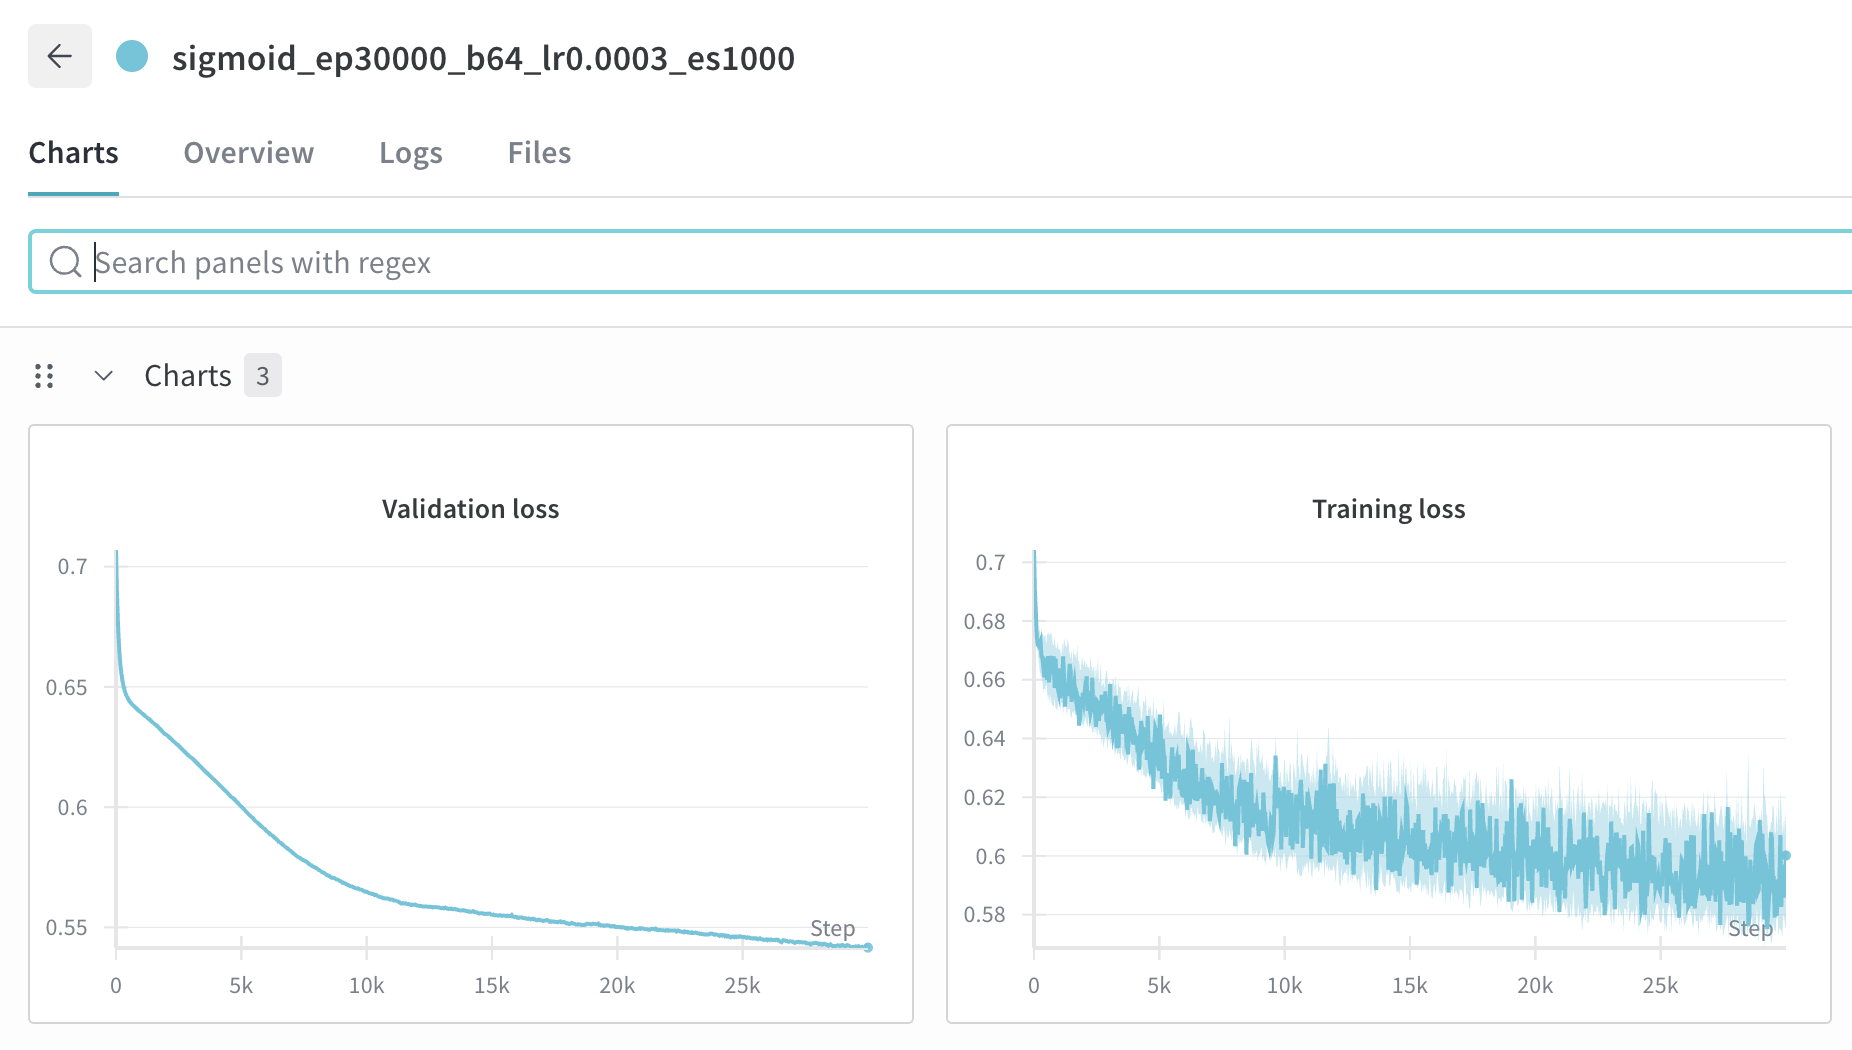
- 완만한 수렴, 손실 감소 속도가 매우 느림.
- 결론: 학습 효율이 낮고 최종 loss가 가장 높아 부적합.

### elu
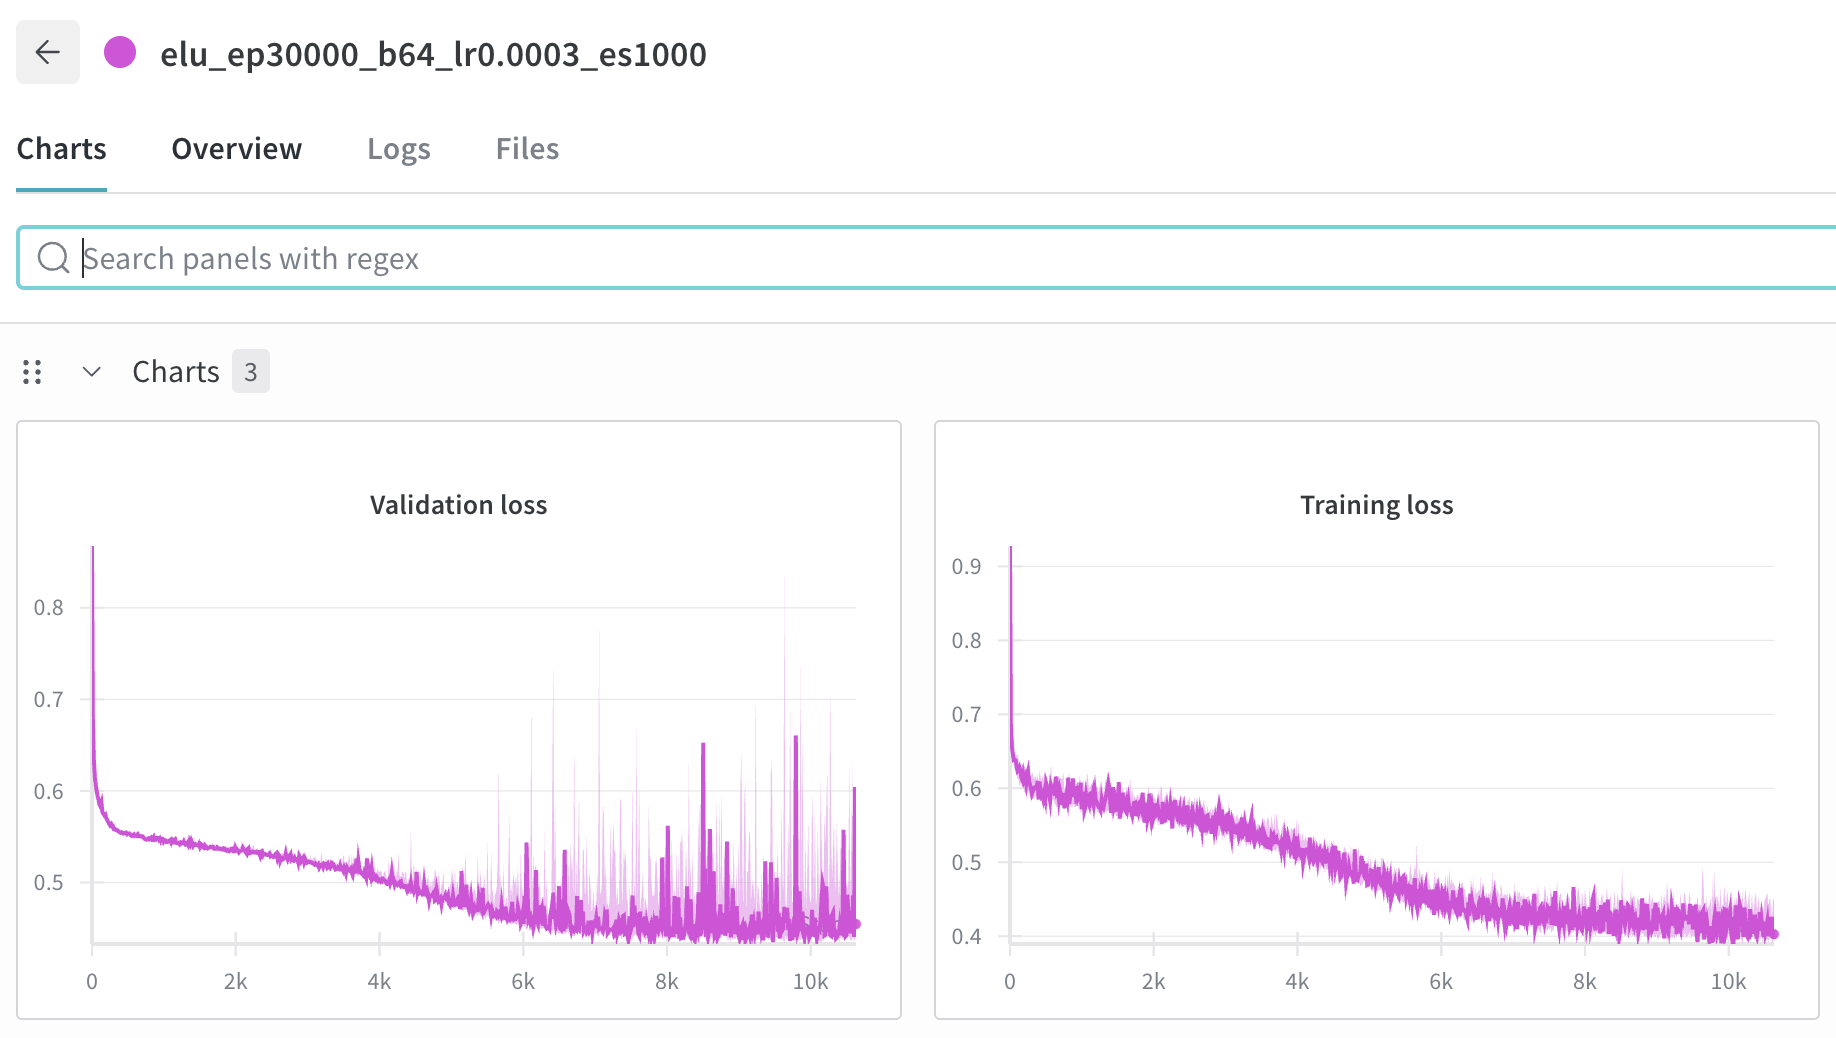
- 초반 수렴은 빠르지만 중반 이후 진폭이 커지며 불안정,
- 결론: 평균 loss가 낮지 않고 진동이 커 일관성 부족.
### relu
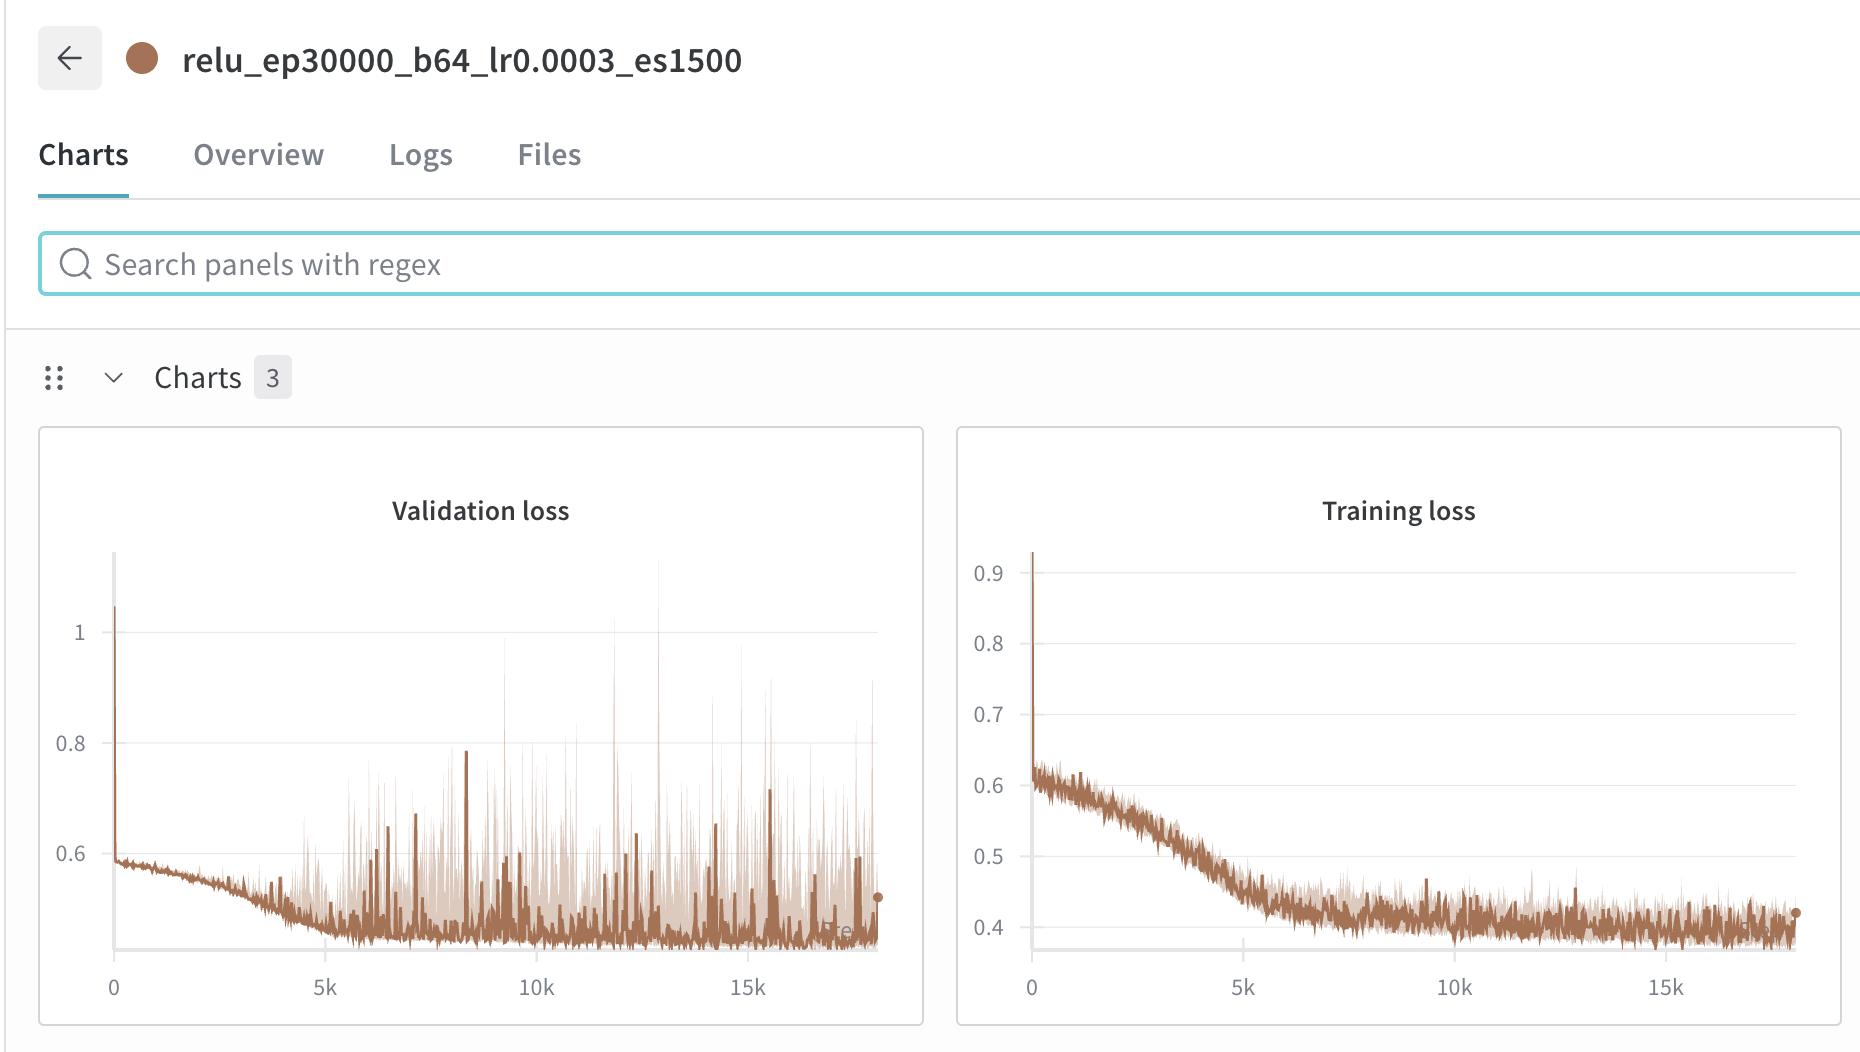
- 빠른 수렴, 그러나 중후반부에 loss 진동이 크게 나타남.
- 결론: 빠른 학습은 가능하지만 일관성 및 일반화 안정성이 떨어짐.
### leaky_relu
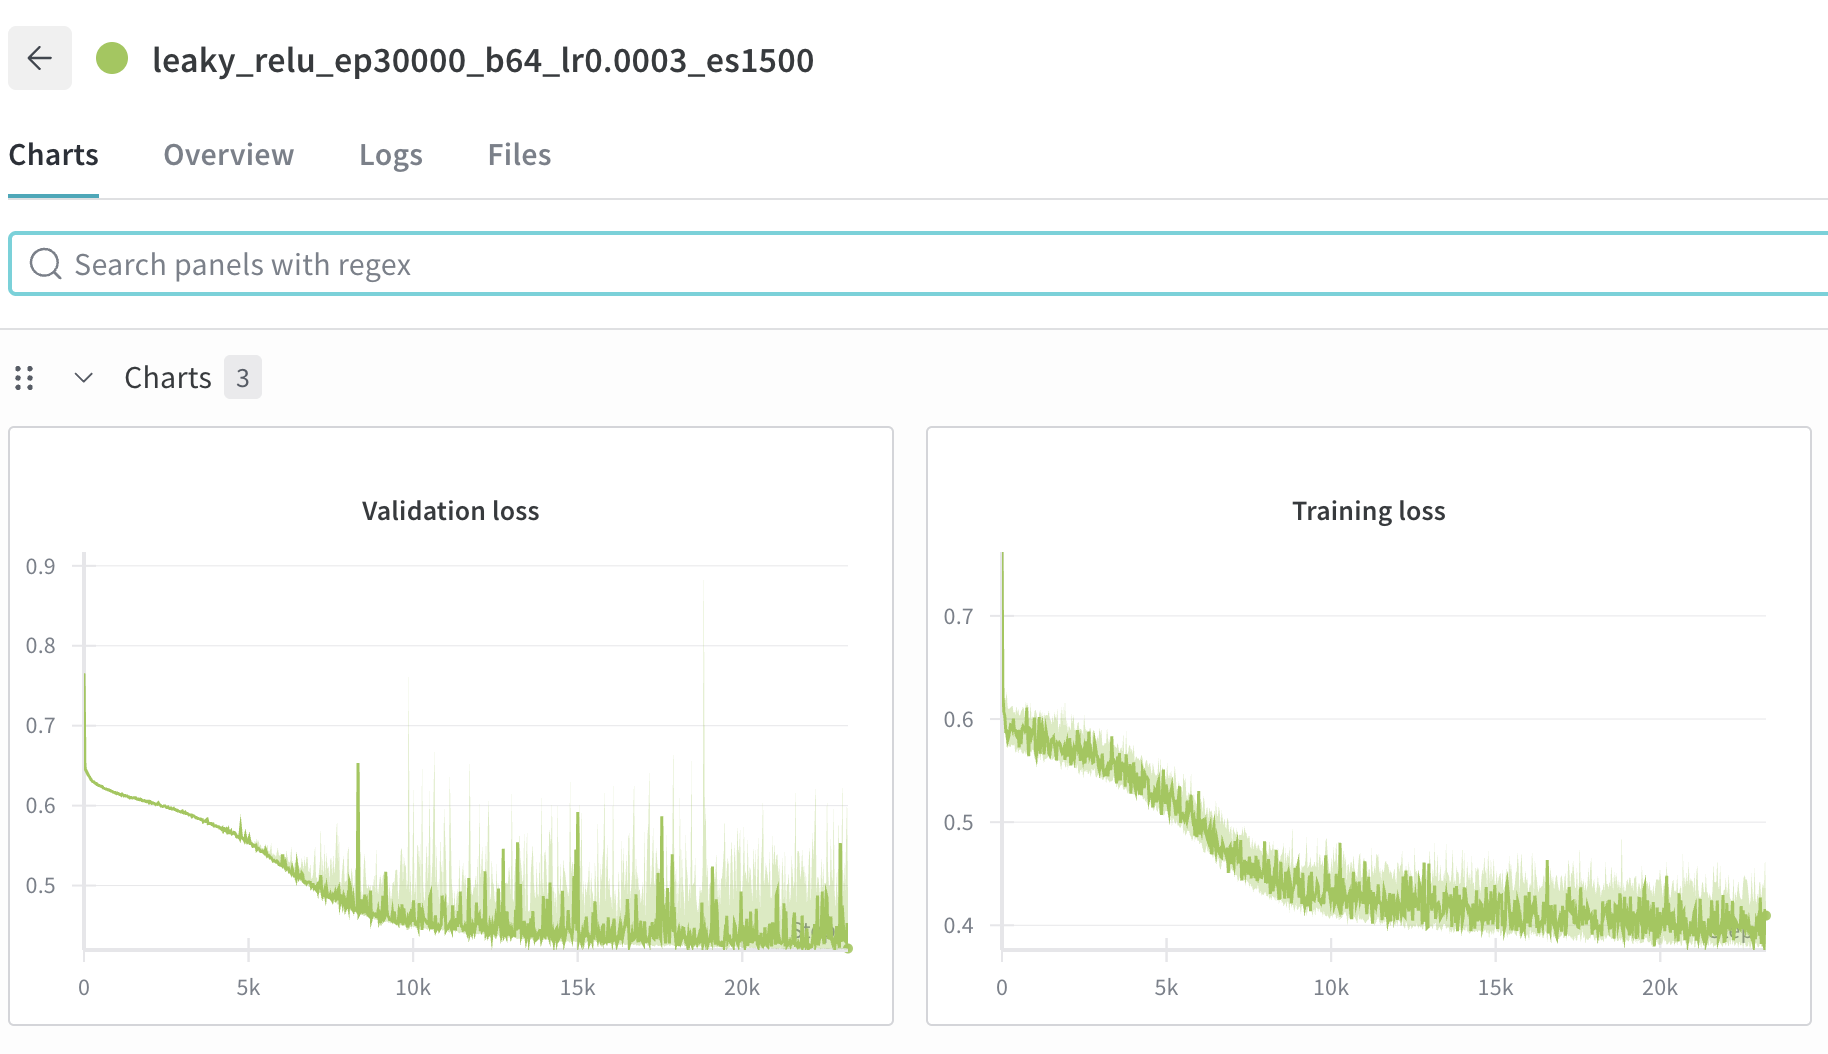
- 완만하지만 지속적인 loss 감소와 낮은 진동 폭.
- 훈련 및 검증 loss 모두 안정적으로 하락.
- 결론: 평균 validation loss가 가장 낮고 수렴 안정성이 좋음.

### 최종 결론
ReLU 계열 중 가장 안정적이고 validation loss 진동이 최소화되었다.
조건을 일정하게 통일한 실험 (동일 학습률(lr = 0.0003)과 patience = 1500 조건)에서 가장 낮은 평균 loss로
안정적으로 수렴했기 때문에 최종적으로 Leaky ReLU를 선택하였다.

## Batch Size 비교
### Batch Size = 16
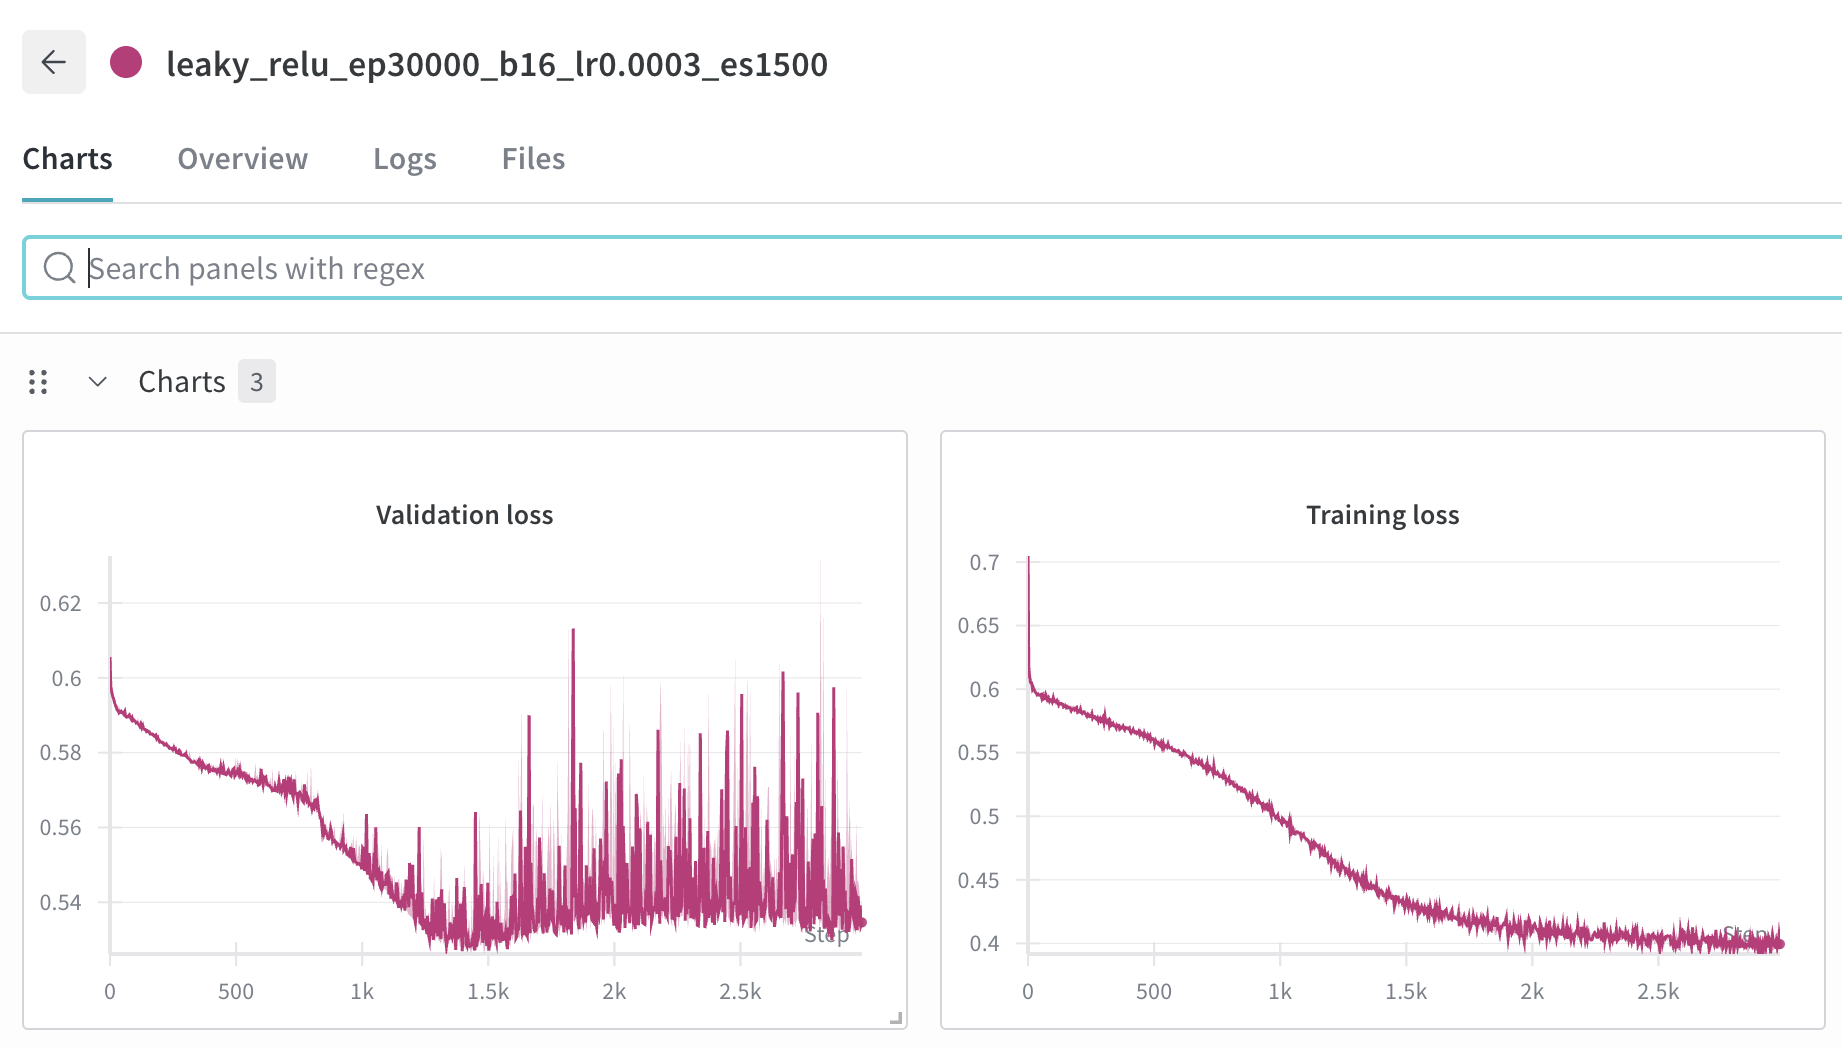
매우 빠르지만 노이즈가 엄청나고, 노이즈 때문에 조기종료, 일반화 불안정
### Batch Size = 32
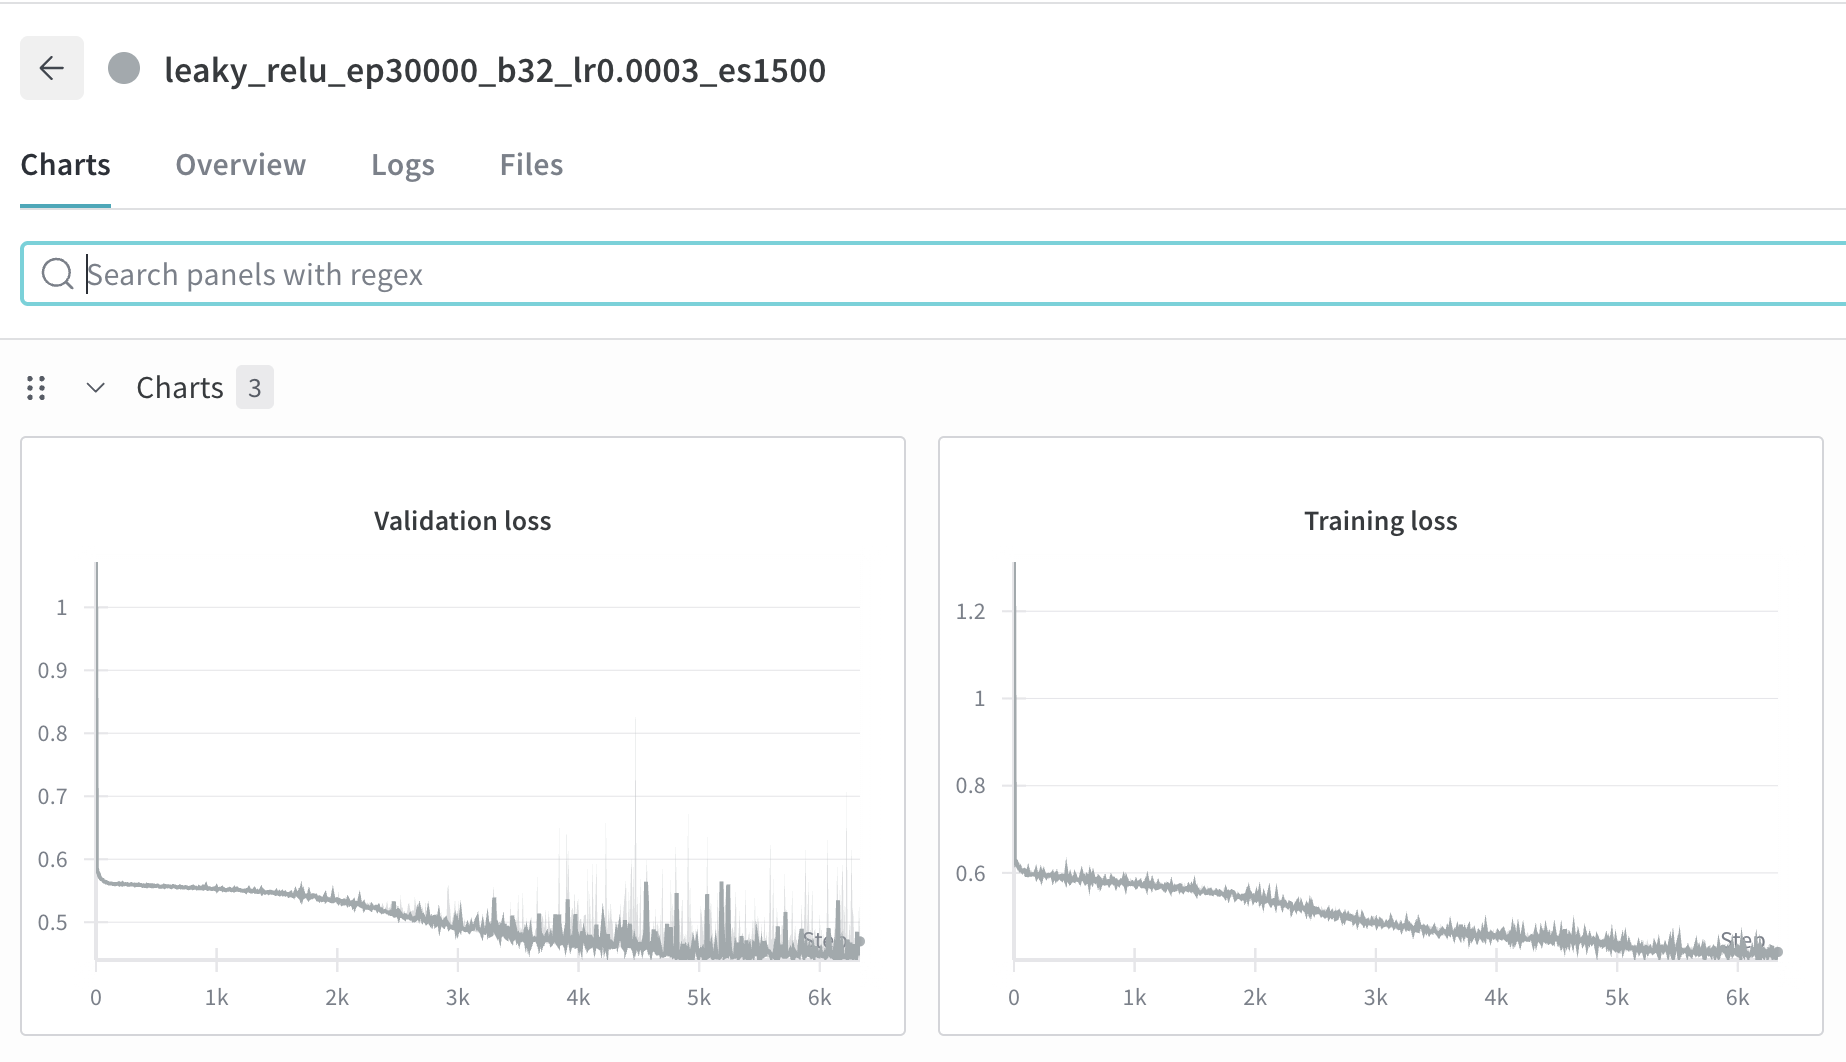
수렴 부드럽고 안정적,
Training loss: 완만하게 지속 감소, 진동 작음.
Validation loss: 낮은 진폭으로 꾸준히 감소, 후반부 안정적.
학습 속도도 빠르고, 과적합도 없음.
### Batch Size = 64
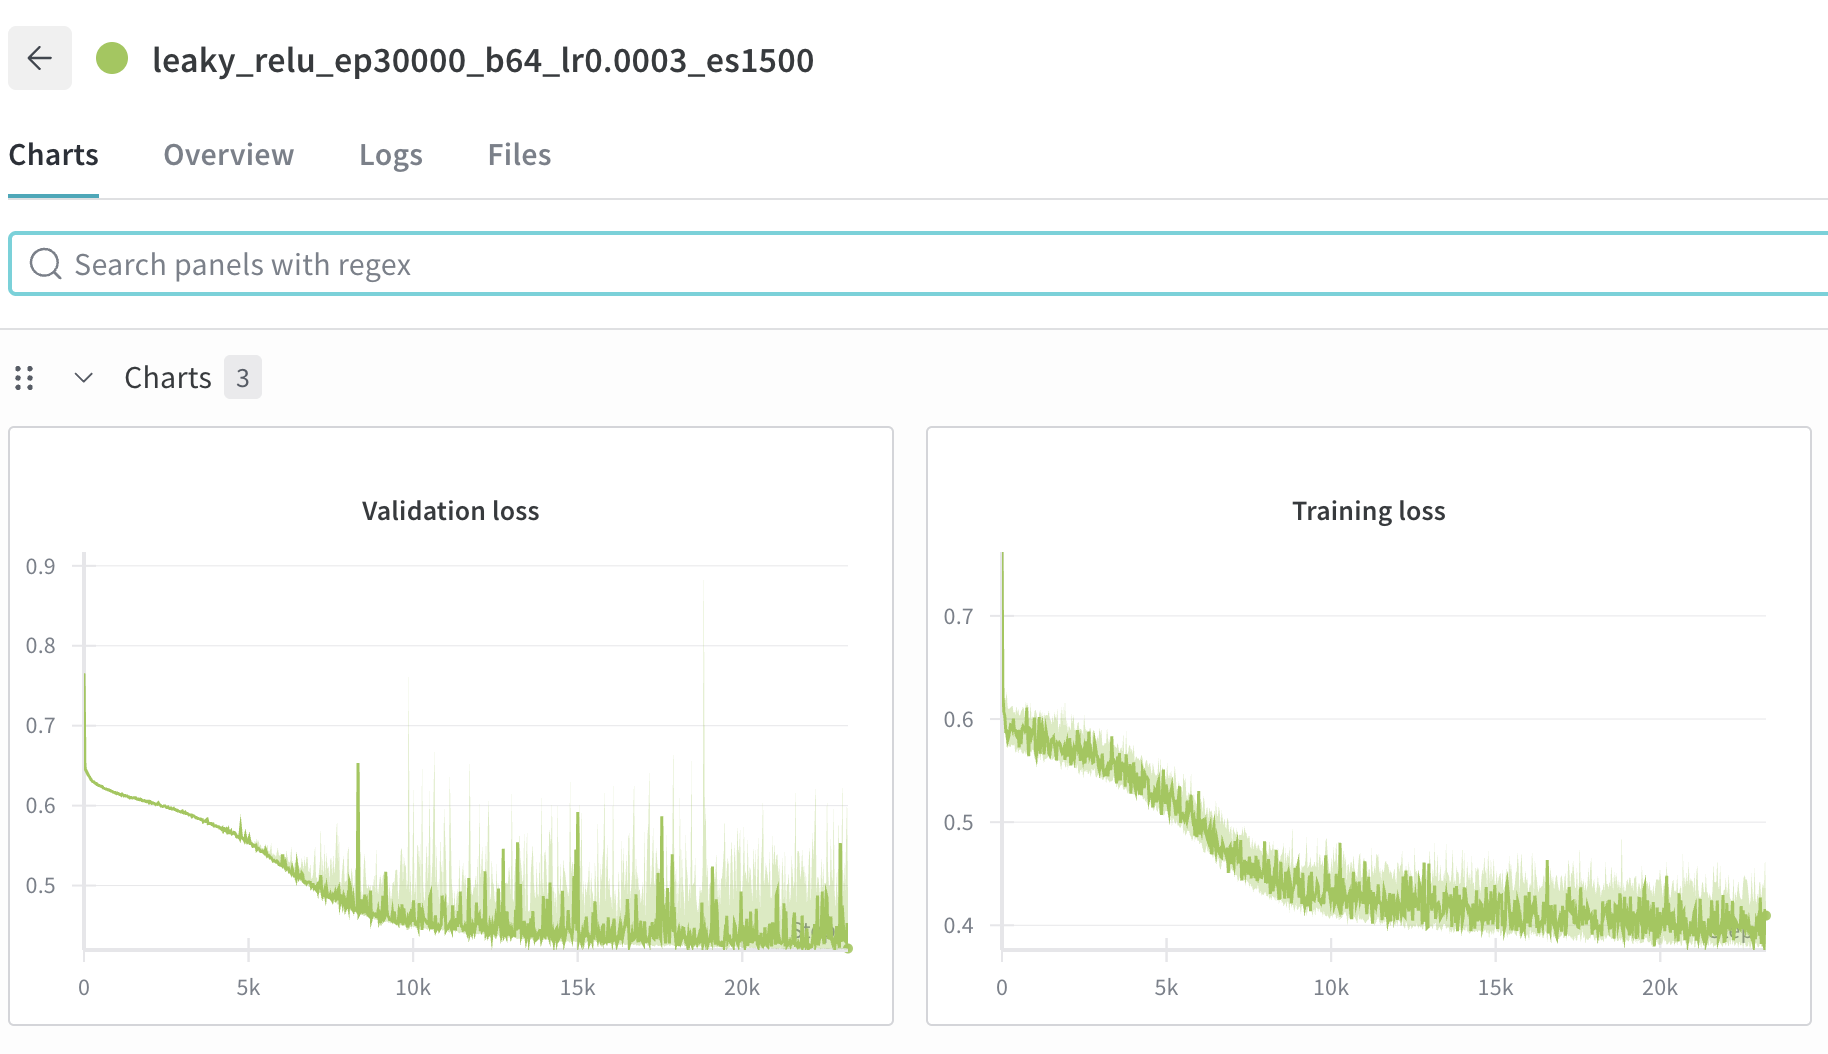
꾸준한 감소는 있지만 진동이 있는편
Training loss: 수렴 양호하나 32보다 noise 크기 증가.
Validation loss: 중반 이후 약간의 진동 발생.
### Batch Size = 128
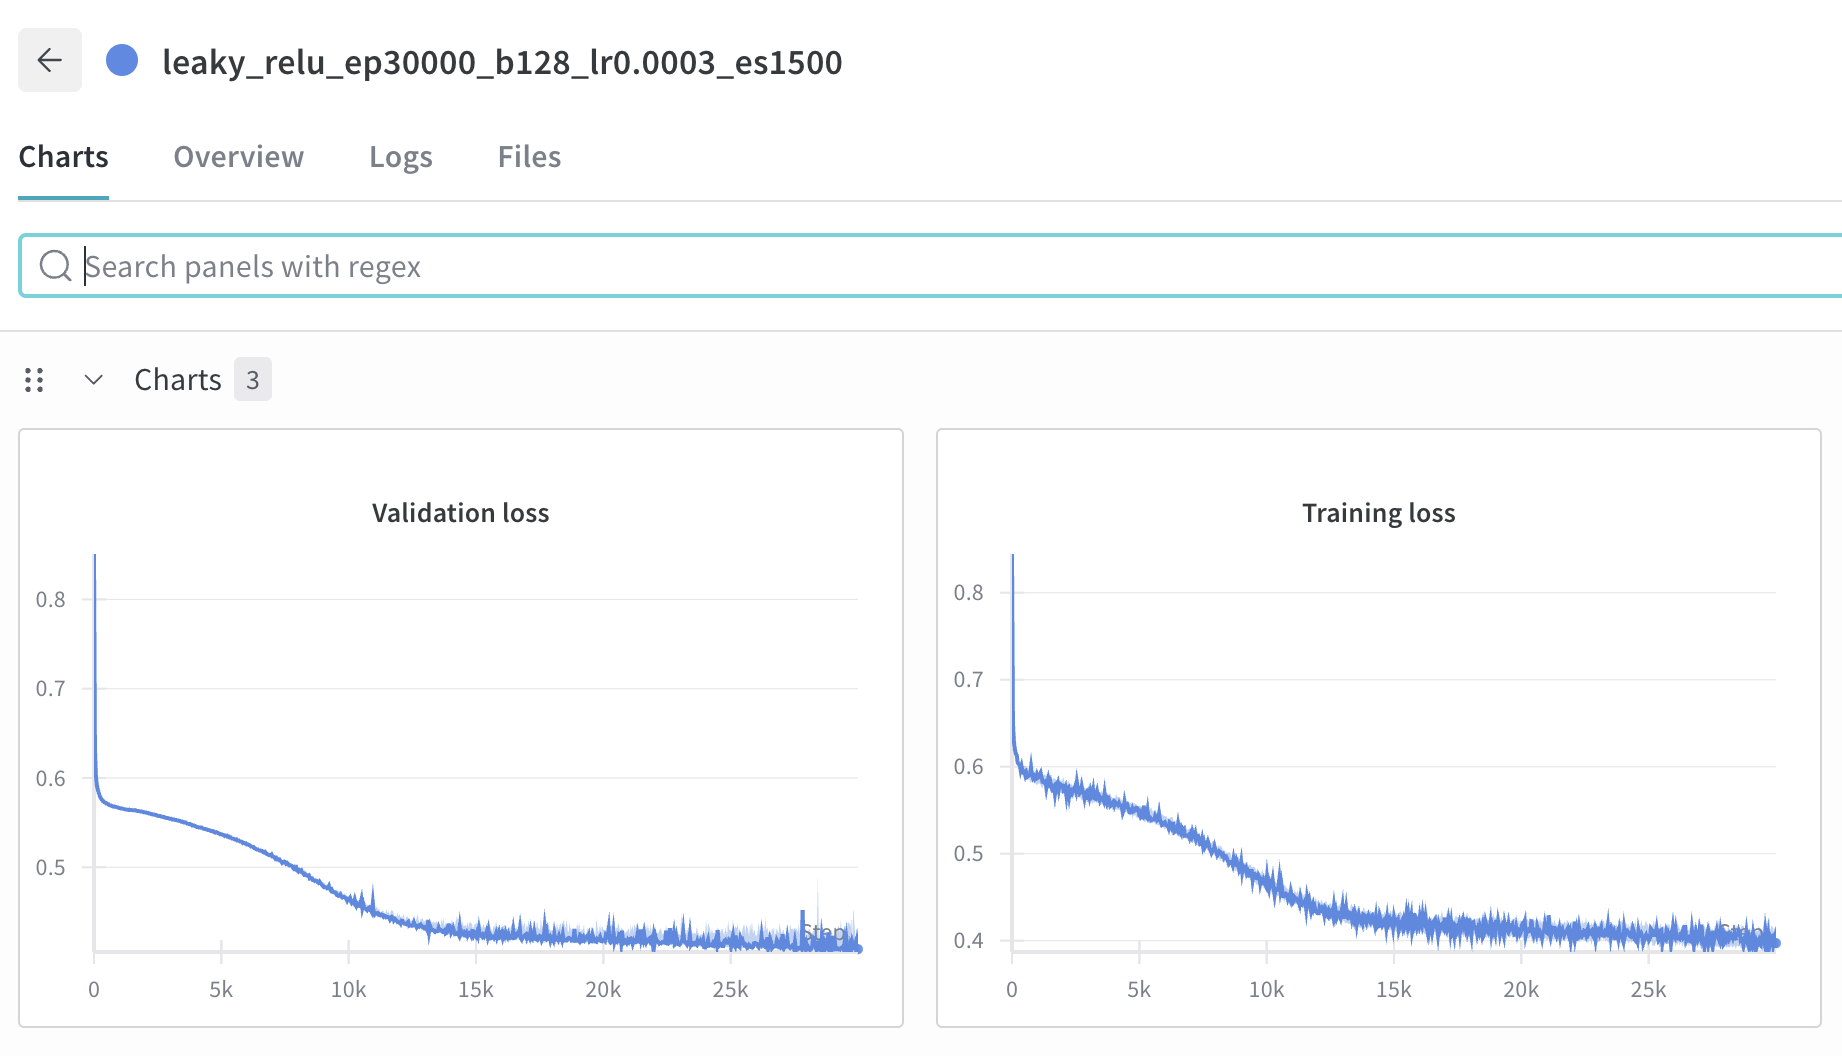
학습이 엄청 오래걸린다. 느리게 수렴하지만 진동은 거의 없다

## 결론
작은 배치(16, 32)는 초반 탐색이 적극적이라 빠르게 loss를 낮추지만, 경계가 요동해 검증 단계에서 오분류가 늘 수 있다. 128은 느리지만 경계가 매끈하게 형성되어 최종 분류 성능이 올라간다. 높은 점수가 목표이기 떄문에, 128로 선택하였다.

# 3. 테스트 & submission.csv 생성

## 최종 모델 구성 및 테스트 전략

### 1. 선택된 하이퍼파라미터
위의 실험 결과를 바탕으로 다음과 같이 최종 하이퍼파라미터를 선택했습니다:
- **Activation Function**: `leaky_relu`
- **Batch Size**: `128`
- **Learning Rate**: `0.0003`
- **Patience**: `1500` (기존 1000에서 증가)

### 2. Patience 조정 이유 (1000 → 1500)
Batch size를 128로 증가시키면서 patience도 1000에서 1500으로 조정했습니다.
patience를 늘려 모델이 충분히 탐색할 시간을 갖고 싶었습니다.
조기 종료를 너무 빨리 하면 최적 성능을 놓칠 수 있을것 같았습니다.

### 3. 테스트 데이터 로더 구성
테스트 데이터 로더는 이미 `get_data()` 함수에서 구현되어 있습니다:
- `TitanicTestDataset` 클래스를 사용하여 테스트 데이터와 PassengerId를 함께 관리
- keggle에 제출할 때 passengerId가 필요하기 떄문에 코드를 수정했습니다.
- 전체 테스트 데이터를 한 번에 처리 (batch_size=len(test_dataset))

### 4. 어느 Epoch에서 테스트를 수행할 것인가?

**핵심 전략: 최소 validation loss를 기록한 checkpoint 사용**

학습 과정에서 테스트를 수행할 시점 선택은 매우 중요합니다:

#### 최종 Epoch 사용 (잘못된 접근)
- 최종 epoch시점에는 종종 과적합(overfitting)이 발생한 상태
- Training loss는 계속 감소하지만 validation loss는 증가
- 테스트 데이터에 대한 일반화 성능이 떨어짐
- 모델이 데이터를 암기하기 시작하기 떄문에, 최적의 성능을 보장하지 않음

#### Best Validation Checkpoint 사용 (기존 코드 참고)
- Early stopping이 자동으로 **최소 validation loss 시점**의 모델을 저장
- 이 시점이 학습과 일반화의 최적 균형점
- 과적합 전의 가장 일반화 성능이 좋은 모델에 submission을 생성

#### 구현 방법
코드 전문의 `main()` 함수에서 이미 구현되어 있습니다:
```python
# 학습 완료 후 best checkpoint 로드
if best_info and 'checkpoint_file_path' in best_info:
    my_model.load_state_dict(torch.load(best_info['checkpoint_file_path']))
    
# 로드된 best model로 submission 생성
generate_submission(my_model, test_data_loader, filename=submission_filename)
```

이 방식으로 **최적의 일반화 성능을 가진 모델**로 테스트 데이터에 대한 예측을 수행합니다.

In [22]:
# ===== 최종 모델 학습 및 Submission 생성 =====

# Section 2 실험 결과를 바탕으로 최종 하이퍼파라미터 설정
class Args:
    wandb = True                    # WandB 로깅 활성화 (학습 과정 모니터링)
    batch_size = 128                # Section 2에서 선택: 안정적 수렴, 낮은 진동
    epochs = 30000                  # 최대 에폭 수
    activation = "leaky_relu"       # Section 2에서 선택: 최소 validation loss, 안정적 수렴
    learning_rate = 0.0003          # 최적 학습률
    early_stop = True               # Early Stopping 활성화
    patience = 1500                 # batch_size=128에 맞춰 1000→1500으로 증가
    generate_submission = True      # 학습 후 submission.csv 자동 생성
    save_best_submission = False    

args = Args()

# 최종 학습 시작
main(args)

{'epochs': 30000, 'batch_size': 128, 'learning_rate': 0.0003, 'n_hidden_unit_list': [20, 20], 'activation': 'leaky_relu', 'early_stopping': True, 'patience': 1500, 'early_stop_delta': 1e-05, 'save_best_submission': False}
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      

/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

Epoch 100, Training loss 0.6298, Validation loss 0.6287 | V_loss decreased (0.62902 --> 0.62874). Saving model...
Epoch 200, Training loss 0.6136, Validation loss 0.6137 | V_loss decreased (0.61373 --> 0.61365). Saving model...
Epoch 300, Training loss 0.6100, Validation loss 0.6077 | V_loss decreased (0.60769 --> 0.60766). Saving model...
Epoch 400, Training loss 0.6089, Validation loss 0.6039 | V_loss decreased (0.60396 --> 0.60390). Saving model...
Epoch 500, Training loss 0.6000, Validation loss 0.6009 | V_loss decreased (0.60088 --> 0.60086). Saving model...
Epoch 600, Training loss 0.6007, Validation loss 0.5984 | V_loss decreased (0.59838 --> 0.59835). Saving model...
Epoch 700, Training loss 0.5950, Validation loss 0.5959 | V_loss decreased (0.59595 --> 0.59593). Saving model...
Epoch 800, Training loss 0.5973, Validation loss 0.5937 | V_loss decreased (0.59370 --> 0.59368). Saving model...
Epoch 900, Training loss 0.6008, Validation loss 0.5916 | V_loss decreased (0.59159 --> 

Epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇████
Training loss,█▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▄▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
Validation loss,█▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Epoch,25424
Training loss,0.39478
Validation loss,0.43531


# 4. submission.csv 제출 및 등수 확인
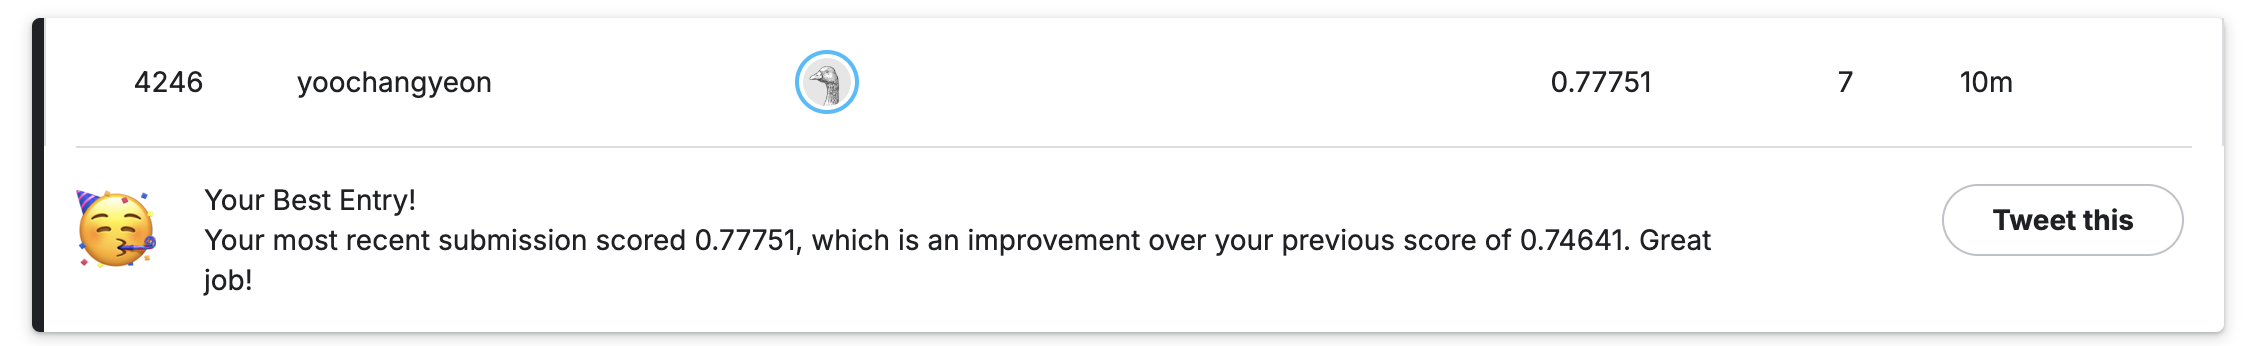

# 5. 숙제 후기

이번 숙제는 딥러닝을 처음 접하면서 처음으로 '실전(?)' 을 느낀 시간이었습니다.

처음에는 이론적 지식이 부족하여 어떻게 모델을 최적화해야 할지 막막했습니다.
그래서 여러 파라미터를 바꿔가며 반복적으로 실행했고, 필요할 떄는 keggle에 제출해가면서 실험하는 경험적 최적화(empirical optimization) 방식으로 접근했습니다
- Activation function 변경 (sigmoid, relu, elu, leaky_relu)
- Batch size 조정 (16, 32, 64, 128)
- Learning rate 튜닝 (0.0002, 0.0003, 0.0005)
- Patience 값 조정 (1000 → 1500)

사실 아직도 모든 이론이 이해가 가거나, 최적화를 어떻게 해야하는지 잘 모르겠습니다.
각 실험을 진행하면서 궁금한 점은 인터넷 검색과 GPT를 활용하여 해결했습니다. 예를 들어:
- "왜 Leaky ReLU가 ReLU보다 안정적인가?"
- "Batch size가 클수록 왜 학습이 느려지는가?"
- "Early stopping의 patience를 어떻게 설정해야 하는가?"

이러한 질문들을 통해 이론과 실전을 연결하면서 점차 이해의 폭을 넓혀갈 수 있었습니다.
실험을 반복하면서 Kaggle 점수가 조금씩 올라가는 과정이 재밌었습니다.
각 파라미터 변경이 실제 성능에 어떤 영향을 미치는지 직접 확인하면서, 딥러닝 모델 최적화에 대한 감을 잡을 수 있었습니다. (정말 감만 잡았습니다..)

수업에서 배운 다양한 개념들이 실제로 어떻게 적용되는지 체감할 수 있었습니다:
- **Activation Function**: 각 함수의 특성이 학습 안정성과 수렴 속도에 실제로 영향을 미친다
- **Batch Size**: 작은 배치는 빠르지만 불안정하고, 큰 배치는 느리지만 안정적이다
- **Early Stopping**: 과적합을 방지하고 최적의 일반화 성능을 찾는 실용적 기법이다
- **Learning Rate**: 너무 크면 발산하고, 너무 작으면 학습이 느리다는 것을 직접 경험했다

처음에는 막막했지만,이론만 공부했을 때 보다는 추상적으로 느껴졌던 개념들이 실제 데이터와 성능 지표를 통해 구체화되는 경험이 재밌었습니다.
특히 점수를 올리는 재미가 있었습니다.